# **Homework 1: Bayesian linear regression**
STAT 348, UChicago, Spring 2025

----------------
**Nicholas Bourdeau**

**Hours spent: 15**


----------------

<a href="https://colab.research.google.com/github/aschein/stat_348_2025/blob/main/assignments/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

This homework focuses on themes in the first three lectures and will also get you familiar with Python and PyTorch which we will use for the rest of the course.

For reference, this homework is a close adaption of [HW1 for Scott Linderman's STATS 305C](https://github.com/slinderman/stats305c/blob/spring2023/assignments/hw1/hw1.ipynb), for which the [slides for lecture 1](https://github.com/slinderman/stats305c/blob/spring2023/slides/lecture01-bayes_normal.pdf) may be a useful reference.

Assignment is due **Sunday April 6, 11:59pm** on GradeScope.


In [1]:
import torch
from torch.distributions import Normal, Gamma, \
    TransformedDistribution, MultivariateNormal
from torch.distributions.transforms import PowerTransform

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

## Bayesian Linear Regression

Let $\{\mathbf{x}_i, y_i\}_{i=1}^n$ denote a dataset with covariates $\mathbf{x}_i \in \mathbb{R}^p$ and scalar outcomes $y_i \in \mathbb{R}$. Let $\mathbf{X} \in \mathbb{R}^{n \times p}$ denote the design matrix where each row is a vector of covariates and $\mathbf{y} \in \mathbb{R}^n$ denote the vector of outcomes.

We will model the outcomes as conditionally independent Gaussian random variables given the covariates and the parameters,

$$
\begin{align*}
p(\mathbf{y} \mid \boldsymbol{\beta}, \sigma^2, \mathbf{X})
&= \prod_{i=1}^N \mathcal{N}(y_i \mid \mathbf{x}_i^\top \boldsymbol{\beta},\, \sigma^2),
\end{align*}
$$

where $\boldsymbol{\beta} \in \mathbb{R}^p$ are the _regression coefficients_ and $\sigma^2 \in \mathbb{R}_+$ is the _conditional variance_.

As discussed in [lecture 2](https://github.com/aschein/stat_348_2025/blob/main/lecture_materials/ipad_notes/lecture_2.pdf), in _Bayesian_ linear regression we place a priors over the parameters. In lecture, we placed a simple multivariate Gaussian prior over the coefficients $\boldsymbol{\beta}$ and treated the variance $\sigma^2$ as a fixed and known hyperparameter. In this homework, we will place a _joint prior over both_ parameters. We first place a _scaled inverse chi-squared_ prior over $\sigma^2$:
$$
\begin{align*}
P(\sigma^2 \mid v_0, \tau_0^2) &= \chi^{-2}(\sigma^2;\, v_0, \tau_0^2) \\
&= \frac{(\tfrac{\nu_0 \tau_0^2}{2})^{\tfrac{\nu_0}{2}}}{\Gamma(\tfrac{\nu_0}{2})} (\sigma^2)^{-\tfrac{\nu_0}{2}-1}\exp(-\tfrac{\nu_0\tau_0^2}{2\sigma^2})\\
\end{align*}
$$
where $\nu_0 \in \mathbb{R}_+$ is the _prior degrees of freedom_ and $\tau_0^2 \in \mathbb{R}_+$ is the _prior mean_ of $\sigma_2$. We then place a Gaussian prior over $\boldsymbol{\beta}$:
$$P(\boldsymbol{\beta} \mid \sigma^2, \mathbf{m}_0,\, L_0) = \mathcal{N}(\boldsymbol{\beta};\, \textbf{m}_0, \sigma^2 L_0^{-1})$$
where $\mathbf{m}_0 \in \mathbb{R}^p$ is the _prior mean_ of the coefficients, and $L_0$ is a positive definite $p \times p$ _precision matrix_. We collect all *hyperparameters* into the vector $\boldsymbol{\eta}_0 = (\nu_0, \tau_0^2, \mathbf{m}_0, L_0)$.

Notice that the prior over $\boldsymbol{\beta}$ _depends on_ $\sigma^2$. We can equivalently express the joint prior over both parameters as the _normal inverse chi-squared distribution (NIX)_:
$$
\begin{align*}
P(\boldsymbol{\beta}, \sigma^2 \mid \boldsymbol{\eta}_0) &= \textrm{NIX}(\boldsymbol{\beta},\,\sigma^2;\,  \textbf{m}_0, L_0, v_0, \tau_0^2) \\
&= \chi^{-2}(\sigma^2;\, v_0, \tau_0^2) \,\mathcal{N}(\boldsymbol{\beta};\, \textbf{m}_0, \sigma^2 L_0^{-1})
\end{align*}
$$
The **normal inverse chi-squared (NIX) distribution is a conjugate prior for the likelihood** in equation 1.



## PyTorch

You will use PyTorch to complete the coding portions of this assignment. If you are unfamiliar with PyTorch, [this](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) webpage provides an introductory tutorial to PyTorch tensors. Another good resource is [homework 0 of STAT 305C](https://github.com/slinderman/stats305c/blob/spring2023/assignments/hw0/hw0.ipynb), which you could work through for practice.

## Problem 1: Derive the Posterior [Math]

Derive the posterior distribution $p(\boldsymbol{\beta}, \sigma^2 \mid \mathbf{y}, X, \boldsymbol{\eta}_0)$ where $\boldsymbol{\eta}_0 = (\nu_0, \sigma_0^2, \mathbf{m}_0, L_0)$. Since the NIX distribution is the conjugate prior, the posterior should be of the same form as the prior (i.e., another NIX distribution):

$$
\begin{align*}
p(\boldsymbol{\beta}, \sigma^2 \mid \mathbf{y}, X, \boldsymbol{\eta}_0)
&= \textrm{NIX}(\boldsymbol{\beta},\,\sigma^2;\,  \mathbf{m}_n, L_n, v_n, \tau_n^2) \\
&= \chi^{-2}(\sigma^2 \mid \nu_n, \tau_n^2) \mathcal{N}(\boldsymbol{\beta} \mid \mathbf{m}_n, \sigma^2 L_n^{-1})
\end{align*}
$$

for some _posterior parameters_ $\nu_n$, $\tau_n^2$, $\mathbf{m}_n$, and $L_n$. Your job is to provide the exact form of these parameters.

**Hint 1:** Remember that the "standard procedure" for deriving the posterior distribution is to write down the joint distribution (on both parameters and data), and then only collect the terms involving the parameters to obtain the "kernel" of the posterior. But, in this setting, you have to be very careful to keep both $\boldsymbol{\beta}$ and $\sigma^2$, because we are asking for the _joint posterior_.

**Hint 2:** When working with quadratic forms, a useful operation is to complete the square; for any $\mathbf{a} \in \mathbb{R}^n$, $B \in \mathbb{R}^{n \times n}$, and $\mathbf{c} \in \mathbb{R}^n$:
$$\mathbf{a}^\top B \mathbf{a} - 2\mathbf{a}^\top B \mathbf{c} = (\mathbf{a} - \mathbf{c})^\top B (\mathbf{a} - \mathbf{c}) - \mathbf{c}^\top B \mathbf{c}$$


---

_Your answer here._

---

## Problem 2: The Posterior Mean [Math]
a. What does the posterior mean $\mathbb{E}[\boldsymbol{\beta} \mid \mathbf{y}, X, \boldsymbol{\eta}_0]$ equal in the uninformative limit where $L_0 \to 0$ and $\nu_0 \to 0$?

b. What does the posterior mean $\mathbb{E}[\sigma^2 \mid \mathbf{y}, X, \boldsymbol{\eta}_0]$ equal in the uninformative limit where $L_0 \to 0$ and $\nu_0 \to 0$? Write your answer in terms of the _hat matrix_ $\mathbf{H} = X (X^\top X)^{-1} X^\top$.

---

_Your answer here._

---

## Synthetic Data

We'll do some simple analysis of a synthetic dataset with $n =20$ data points. Each data point has covariates $\mathbf{x}_i = (1, x_i) \in \mathbb{R}^2$ and scalar outcomes $y_i \in \mathbb{R}$. It looks like this:

--2025-03-31 16:43:40--  https://github.com/aschein/stat_348_2025/raw/main/assignments/hw1.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aschein/stat_348_2025/main/assignments/hw1.pt [following]
--2025-03-31 16:43:41--  https://raw.githubusercontent.com/aschein/stat_348_2025/main/assignments/hw1.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [application/octet-stream]
Saving to: ‘hw1.pt.2’

hw1.pt.2            100%[===================>]   1.16K  --.-KB/s    in 0s      

2025-03-31 16:43:41 (36.0 MB/s) - ‘hw1.pt.2’ saved [1191/1191]



Text(0, 0.5, '$y$')

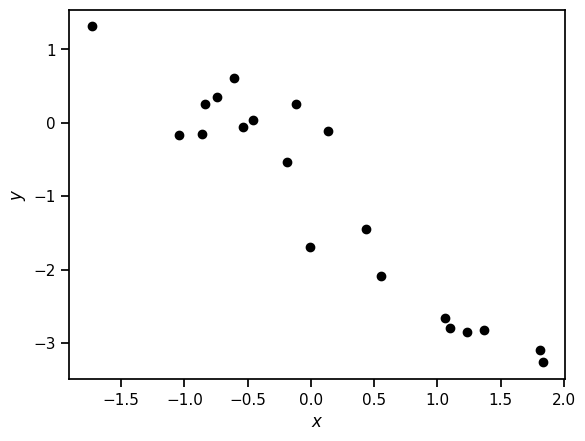

In [10]:
# Download the data (uncomment the line below)
!wget https://github.com/aschein/stat_348_2025/raw/main/assignments/hw1.pt

# Load the data.
#X = [[1, x_1]
#    [1, x_2]
#        ...
#    [1, x_N]]
#
#y = [y_1, ..., y_N]
X, y = torch.load("hw1.pt")

plt.plot(X[:, 1], y, 'ko')
plt.xlabel("$x$")
plt.ylabel("$y$")

Here, the outcomes were simulated from a linear regression with Gaussian noise according to some true parameters (not given). You will compute and visualize the posterior distribution over the weights and variance given the data.

## Problem 3: Compute the posterior [Code]

Write a function to compute the posterior parameters given data and hyperparameters.

*Hints*: You may find the following commands in PyTorch useful:
- If ```a``` is a tensor, ```a.shape``` is a tuple containing the shape of ```a```.
- If ```a``` is a tensor, ```a.T``` returns the transpose of ```a```.
- ```torch.linalg.solve```
- ```*``` denotes element-wise multiplication while ```@``` denotes standard matrix-matrix or matrix-vector multiplication.

In [49]:
def compute_posterior(X, y, nu_0, tau_0, m_0, L_0):
    """
    Compute the posterior parameters nu_n, tau_n, m_n, and L_n
    given covariates X, outcomes y, and hyperparameters.

    Args:
        X:          (n, p) tensor of covariates
        y:          (n,) tensor of outcomes
        nu_0:       prior degrees of freedom
        tau_0:  prior mean of the variance parameter
        m_0:       prior mean of the weights
        L_0:   prior precision of the weights

    Returns:
        nu_n:       posterior degrees of freedom
        tau_n:  posterior scale of the variance parameter
        m_n:       posterior mean of the weights
        L_n:   posterior precision of the weights
    """
    ##
    L_n = X.T @ X + L_0
    m_n = torch.inverse(L_n) @ (X.T @ y + L_0 @ m_0)
    nu_n = nu_0 + X.size()[0]
    tau_n = ((y.T @ y) + (nu_0 * (tau_0 ** 2)) + (m_0.T @ L_0 @ m_0) -
     (m_n.T @ L_n @ m_n))/ nu_n
    #
    ##
    return nu_n, tau_n, m_n, L_n



Please run the following code to print your answers:

In [50]:
# Test:
hyperparams = dict(
    nu_0=torch.tensor(1.0),
    tau_0=torch.tensor(1.0),
    m_0=torch.zeros(2),
    L_0=0.1 * torch.eye(2)
)


nu_n, tau_n, m_n, L_n = compute_posterior(X, y, **hyperparams)
print("nu_n:       \n", nu_n)
print("")
print("tau_n:  \n", tau_n)
print("")
print("m_n:       \n", m_n)
print("")
print("L_n:   \n", L_n)

nu_n:       
 tensor(21.)

tau_n:  
 tensor(0.2733)

m_n:       
 tensor([-0.8777, -1.3646])

L_n:   
 tensor([[20.1000,  2.4126],
        [ 2.4126, 20.0170]])


## Problem 4: Plot the posterior density of the variance [Code]

Plot $p(\sigma^2 \mid X, \mathbf{y}, \boldsymbol{\eta}_0)$ vs $\sigma^2$ over the interval $[10^{-3}, 2]$, where $X$ and $\mathbf{y}$ continue to be the synthetic data we downloaded and used in Problem 3.

You may use the `ScaledInvChiSq` distribution object below, which we copied from the demo for Lecture 1.

_Hint_: In Python, you can use `dir(object)` to list the attributes and functions that an object supports.

_Hint_: To learn more about PyTorch distributions, see the [docs](https://pytorch.org/docs/stable/distributions.html).

In [ ]:
class ScaledInvChiSq(TransformedDistribution):

    def __init__(self, dof, scale):
        """
        Implementation of the scaled inverse \chi^2 distribution,

        ..math:
            \chi^{-2}(\nu_0, \tau_0^2)

        It is equivalent to an inverse gamma distribution, which we implement
        as a transformation of a Gamma distribution. Thus, this class inherits
        functions like `log_prob` from its parent.

        Args:
            dof:   degrees of freedom parameter
            scale: scale of the $\chi^{-2}$ distribution.
        """
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

In [ ]:
##
# YOUR CODE HERE
#
##

## Problem 5: Plot posterior samples of the regression function. [Code]
Draw 50 samples from the posterior marginal distribution over the weights $\boldsymbol{\beta} \in \mathbb{R}^2$. For each sample, compute the expected value of $y$ on a grid of points $x$ evenly spaced between $[-3, 3]$. Remember that our covariates were defined as $\mathbf{x} = (1, x)$ so that for each sample of the weights you get a line for $\mathbb{E}[y \mid x, \boldsymbol{\beta}]$ as a function of $x$. Plot these 50 lines on top of each other to get a sense of the posterior uncertainty in the regression function. (You may want to plot each line with some transparency, like `alpha=0.1`.) Overlay the observed data points.

*Hint*: You may find ```torch.inverse``` useful.

*Hint*: Remember that in the generative model we have posited, the distribution of $\boldsymbol{\beta}$ depends on $\sigma^2$.

In [ ]:
##
# YOUR CODE HERE
#
##

## Problem 6: Posterior Predictive Distribution [Math]
The subparts of this problem will walk you through deriving the posterior predictive distribution of the outcome at a new input $\mathbf{x}_{n+1}$. That is, computing,

$$
\begin{align*}
p(y_{n+1} \mid \mathbf{x}_{n+1}, \mathbf{y}, X, \boldsymbol{\eta}_0)
\end{align*}
$$

integrating over the posterior distribution on the coefficients $\boldsymbol{\beta}$ and variance $\sigma^2$.
Remember that you found this posterior distribution in Problem 1, but for the purpose of this question it's enough to leave it in the form

$$
\begin{align*}
p(\boldsymbol{\beta}, \sigma^2 \mid \mathbf{y}, X, \boldsymbol{\eta}_0)
&= \chi^{-2}(\sigma^2 \mid \nu_n, \tau_n^2) \, \mathcal{N}(\boldsymbol{\beta} \mid \mathbf{m}_n, \sigma^2 L_n^{-1}),
\end{align*}
$$

i.e. you don't need to plug in the values for for some $\nu_n$, $\tau_n^2$, $\mathbf{m}_n$, and $L_n$ that you found in Problem 1.



### Problem 6a

Using the product rule of probability, write out the joint distribution of the posterior over the parameters and the observation of the next data point $y_{n+1}$:

$$
\begin{align*}
  p(y_{n + 1}, \boldsymbol{\beta}, \sigma^2 \mid \mathbf{x}_{n + 1}, \mathbf{y}, X, \boldsymbol{\eta}_0).
\end{align*}
$$

You can (and please do) replace any densities from a known family with the notation $\text{symbol for the family}( \text{variable name} \mid \text{parameters})$. (We follow this notation in how we write out the posterior above).

---

_Your answer here._

---

### Problem 6b

Now using the sum rule of probability, compute the posterior predictive distribution

$$
\begin{align*}
  p(y_{n + 1}, | \mathbf{x}_{n + 1}, \mathbf{y}, X, \boldsymbol{\eta}_0) = \int  p(y_{n + 1}, \boldsymbol{\beta}, \sigma^2 \mid \boldsymbol{x}_{n + 1}, \mathbf{y}, X, \boldsymbol{\eta}_0) \,d\boldsymbol{\beta} \,d\sigma^2.
\end{align*}
$$

*Hint:* You can do this integral without taking any integrals! Think about conjugate families and how the Student's T distribution arises (e.g., see [these slides](https://github.com/slinderman/stats305c/blob/spring2023/slides/lecture01-bayes_normal.pdf)).

---

_Your answer here._

---

## Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

Download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw1.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw1.ipynb`)

Possible causes for errors:
  * the "Open in colab" button. Just delete the code that creates this button (go to the top cell and delete it)
  * Latex errors: many latex errors aren't visible in the notebook. Try binary search: comment out half of the latex at a time, until you find the bugs

Getting this HW into PDF form isn't meant to be a burden. One quick and easy approach is to open it as a Jupyter notebook, print, save to pdf. Just make sure your latex math answers aren't cut off so we can grade them.

Please post on Ed or come to OH if there are any other problems submitting the HW.

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions!